# Análise de Crédito com Machine Learning: Predição de Aprovação de Cartões de Crédito

## 1. Definição do Problema

A falta de análise adequada nas aprovações de crédito pode ser uma grande problemática na sociedade. Isso pode ocorrer em situações onde as instituições financeiras estão mais preocupadas em aumentar o número de empréstimos concedidos do que em verificar a capacidade de pagamento dos clientes. Com isso, muitas pessoas acabam se endividando além do que podem pagar, o que pode levar a problemas financeiros graves, como a inadimplência e o endividamento crônico.

Além disso, a falta de análise adequada também pode levar a situações de discriminação financeira, onde algumas pessoas são recusadas no acesso ao crédito sem justificativa plausível. Isso pode ocorrer em razão de preconceitos e estereótipos que muitas vezes são baseados em características pessoais, como idade, gênero, raça, entre outros.

Portanto, é importante que as instituições financeiras realizem uma análise adequada das solicitações de crédito, levando em consideração a capacidade de pagamento dos clientes e sem discriminação de qualquer tipo. Isso contribui para o desenvolvimento de uma sociedade mais justa e equilibrada, onde todos têm as mesmas oportunidades de acesso ao crédito e ao desenvolvimento financeiro.


## 2. Coleta de Dados

### Bases extraídas do Kaggle: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

In [1]:
# Importações das bibliotecas utilizadas para tratamento e visualização dos dados

import pandas as pd
import csv
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
aplicacao = pd.read_csv('application_record.csv')
credito = pd.read_csv('credit_record.csv')

In [3]:
# Visando reconhecer as informações presentes na primeira base de dados "application_record" foram observadas as ->
# 5 primeiras informações de cada coluna.

aplicacao.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


## 3. Processamento/tratamento de dados

### 3.1 Tratamento de dados da primeira base: "application_record.csv"

In [4]:
# Nesta etapa inicial foram removidas algumas colunas com baixa relevância para as análises de aprovação ->
# bem como convertendo os valores negativos em positivos.

aplicacao.drop(['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'], axis=1, inplace=True)
aplicacao['DAYS_EMPLOYED'] = abs(aplicacao['DAYS_EMPLOYED'])
aplicacao['DAYS_BIRTH'] = abs(aplicacao['DAYS_BIRTH'])

In [5]:
# Avaliando se há ID's repetidos na base.

print("Quantidade de linhas na tabela:", aplicacao.shape[0])
print("Quantidade de ID's não repetidos:", aplicacao['ID'].nunique(), '\n')

# Foi verificado que de 438557, 438510 são ID's únicos, logo existem ID's duplicados que estão poluindo a base ->
# mesmo que em pequeno número. Desta forma, serão excluídos os dados duplicados.

aplicacao = aplicacao.drop_duplicates('ID', keep='last')
print("Quantidade de linhas na tabela pós retirada de duplicadas:", aplicacao.shape[0], "\n")

# Seguindo o tratamento inicial dos dados, nota-se a grande quantidade de dados nulos na coluna OCCUPATION_TYPE.
# Este quantitativo de dados nulos representa 30,60% dos dados da coluna, desta forma não é viável considerar ->
# esta coluna para este estudo

print("Verificação de dados nulos na base: \n", aplicacao.isnull().sum(), '\n')
print("Percentual de dados vazios na coluna de Tipo de Ocupação:", aplicacao['OCCUPATION_TYPE'].isnull().sum()/aplicacao.shape[0]*100,"%")

aplicacao.drop(['OCCUPATION_TYPE'], axis=1, inplace=True)

Quantidade de linhas na tabela: 438557
Quantidade de ID's não repetidos: 438510 

Quantidade de linhas na tabela pós retirada de duplicadas: 438510 

Verificação de dados nulos na base: 
 ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
OCCUPATION_TYPE        134187
CNT_FAM_MEMBERS             0
dtype: int64 

Percentual de dados vazios na coluna de Tipo de Ocupação: 30.600670452213173 %


In [6]:
# Verificando os tipos de dados da base atual:

aplicacao.dtypes

# Nota-se que algumas das colunas estão como "object" porém serão convertidas em int64 em breve para a aplicação dos ->
# modelos de ML.

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
CNT_FAM_MEMBERS        float64
dtype: object

<AxesSubplot:xlabel='CNT_FAM_MEMBERS'>

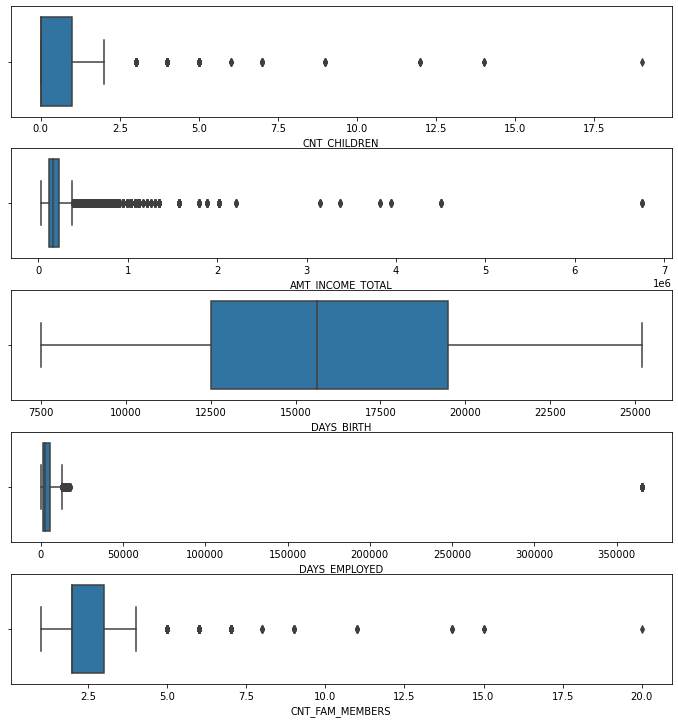

In [7]:
# Para este momento será analisado a existência de outliers das colunas com dados numricos:

fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(10,10))
fig.tight_layout()
sns.boxplot(x=aplicacao["CNT_CHILDREN"], ax=axs[0])
sns.boxplot(x=aplicacao["AMT_INCOME_TOTAL"], ax=axs[1])
sns.boxplot(x=aplicacao["DAYS_BIRTH"], ax=axs[2])
sns.boxplot(x=aplicacao["DAYS_EMPLOYED"], ax=axs[3])
sns.boxplot(x=aplicacao["CNT_FAM_MEMBERS"], ax=axs[4])

# Com exceção da "DAYS_BIRTH", todos os outros dados números possuem outliers, e estes serão eliminados ->
# para melhor consolidação das informações.

<AxesSubplot:xlabel='CNT_FAM_MEMBERS'>

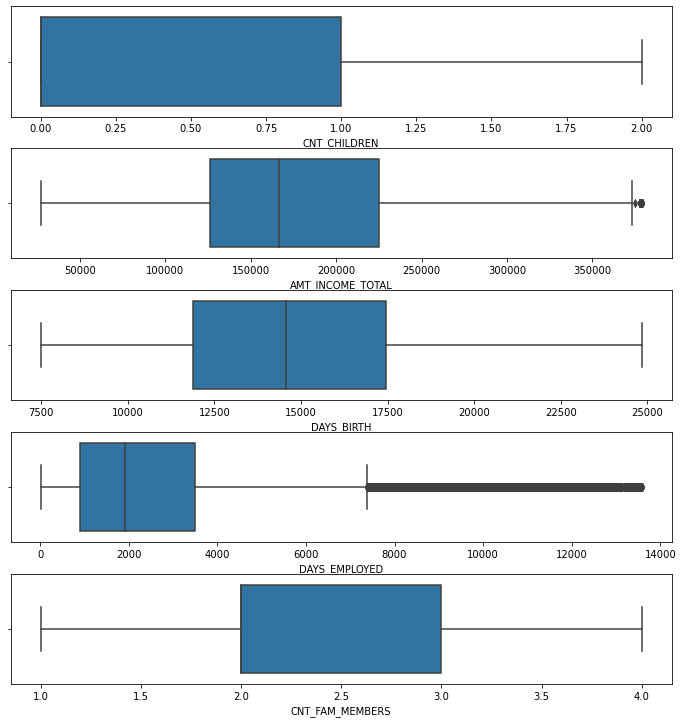

In [8]:
# Utilizando o intervalo interquartil, ou Interquatile Range (IQR -> Q3 - Q1):

# Definição dos quartis para cada uma das colunas e remoção dos outliers da base:

# CNT_CHILDREN
Q1Crianca = aplicacao['CNT_CHILDREN'].quantile(0.25)
Q3Crianca = aplicacao['CNT_CHILDREN'].quantile(0.75)
IQRCrianca = Q3Crianca - Q1Crianca
Crianca_Lim_Inf = Q1Crianca - 1.5*IQRCrianca
Crianca_Lim_Sup = Q3Crianca + 1.5*IQRCrianca
aplicacao = aplicacao[(aplicacao['CNT_CHILDREN'] >= Crianca_Lim_Inf) & (aplicacao['CNT_CHILDREN'] <= Crianca_Lim_Sup)]

# AMT_INCOME_TOTAL
Q1Renda = aplicacao['AMT_INCOME_TOTAL'].quantile(0.25)
Q3Renda = aplicacao['AMT_INCOME_TOTAL'].quantile(0.75)
IQRRenda = Q3Renda - Q1Renda
Renda_Lim_Inf = Q1Renda - 1.5*IQRRenda
Renda_Lim_Sup = Q3Renda + 1.5*IQRRenda
aplicacao = aplicacao[(aplicacao['AMT_INCOME_TOTAL'] >= Renda_Lim_Inf) & (aplicacao['AMT_INCOME_TOTAL'] <= Renda_Lim_Sup)]

# DAYS_EMPLOYED
Q1DiasEmpreg = aplicacao['DAYS_EMPLOYED'].quantile(0.25)
Q3DiasEmpreg = aplicacao['DAYS_EMPLOYED'].quantile(0.75)
IQRDiasEmpreg = Q3DiasEmpreg - Q1DiasEmpreg
DiasEmpreg_Lim_Inf = Q1DiasEmpreg - 1.5*IQRDiasEmpreg
DiasEmpreg_Lim_Sup = Q3DiasEmpreg + 1.5*IQRDiasEmpreg
aplicacao = aplicacao[(aplicacao['DAYS_EMPLOYED'] >= DiasEmpreg_Lim_Inf) & (aplicacao['DAYS_EMPLOYED'] <= DiasEmpreg_Lim_Sup)]

# CNT_FAM_MEMBERS
Q1Membros_Fam = aplicacao['CNT_FAM_MEMBERS'].quantile(0.25)
Q3Membros_Fam = aplicacao['CNT_FAM_MEMBERS'].quantile(0.99)
IQRMembros_Fam = Q3Membros_Fam - Q1Membros_Fam
Membros_Fam_Lim_Inf = Q1Membros_Fam - 1.5*IQRMembros_Fam
Membros_Fam_Lim_Sup = Q3Membros_Fam + 1.5*IQRMembros_Fam
aplicacao = aplicacao[(aplicacao['CNT_FAM_MEMBERS'] >= Membros_Fam_Lim_Inf) & (aplicacao['CNT_FAM_MEMBERS'] <= Membros_Fam_Lim_Sup)]


fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(10,10))
fig.tight_layout()
sns.boxplot(x=aplicacao["CNT_CHILDREN"], ax=axs[0])
sns.boxplot(x=aplicacao["AMT_INCOME_TOTAL"], ax=axs[1])
sns.boxplot(x=aplicacao["DAYS_BIRTH"], ax=axs[2])
sns.boxplot(x=aplicacao["DAYS_EMPLOYED"], ax=axs[3])
sns.boxplot(x=aplicacao["CNT_FAM_MEMBERS"], ax=axs[4])



# *Para a coluna "DAYS_EMPLOYED" de fato existe uma quantidade considerável de outliers, porém é justificável ->
# devido a natureza destes dados. Sempre haverá pessoas com uma maior quantidade de tempo no mercado de trabalho.

In [9]:
#Após a tratativa dos outliers, permanecemos com 339229 linhas.

print("Quantidade de linhas remanescentes:", aplicacao.shape[0])

Quantidade de linhas remanescentes: 339229


### 3.2 Tratamento de dados da segunda base: "credit_record.csv"

In [10]:
print("Resumo das informações da base:")
print(credito.head(), '\n')

print("Tipos de dados da base:")
print(credito.dtypes, '\n')

print("Quantidade de dados na base:")
print(credito.shape[0], '\n')

print("Tipos de resultados da coluna 'STATUS':")
print(credito['STATUS'].unique(), '\n')
print("Significado dos dados da coluna STATUS:\n")
print("C: Dívida paga neste mês \n")
print("X: Sem dívidas atualmente \n")
print("0: 1-29 dias com atraso no pagamento \n")
print("1: 30-59 dias com atraso no pagamento \n")
print("2: 60-89 dias com atraso no pagamento \n")
print("3: 90-119 dias com atraso no pagamento \n")
print("4: 120-149 dias com atraso no pagamento \n")
print("5: >= 150 dias com atraso no pagamento \n")

# Desta forma reconhecemos que existem diversas informações que diferenciam a situação atual dos clientes na base.
# Estas informações são cruciais para a definição do parâmetro que será utilizado durante os algoritmos de ->
# aprendizado de máquina.

Resumo das informações da base:
        ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C 

Tipos de dados da base:
ID                 int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object 

Quantidade de dados na base:
1048575 

Tipos de resultados da coluna 'STATUS':
['X' '0' 'C' '1' '2' '3' '4' '5'] 

Significado dos dados da coluna STATUS:

C: Dívida paga neste mês 

X: Sem dívidas atualmente 

0: 1-29 dias com atraso no pagamento 

1: 30-59 dias com atraso no pagamento 

2: 60-89 dias com atraso no pagamento 

3: 90-119 dias com atraso no pagamento 

4: 120-149 dias com atraso no pagamento 

5: >= 150 dias com atraso no pagamento 



In [11]:
print(credito['STATUS'].value_counts())

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64


In [12]:
# Seguindo de acordo com a proposta inicial do trabalho: Reconhecimento de padrões de aprovação de crédito ->
# existirão apenas duas respostas APROVADO ou REPROVADO.

# Desta forma, reduziremos a coluna STATUS para 1 - APROVADO, 0 - REPROVADO

credito['STATUS'].replace({'X':1, 'C':1,'0':0, '1':0,'2':0, '3':0,'4':0, '5':0, }, inplace=True)
credito['STATUS'] = credito['STATUS'].astype('int64')

In [13]:
print(credito.dtypes)
print(credito.describe())
print(credito['STATUS'].value_counts())

ID                int64
MONTHS_BALANCE    int64
STATUS            int64
dtype: object
                 ID  MONTHS_BALANCE        STATUS
count  1.048575e+06    1.048575e+06  1.048575e+06
mean   5.068286e+06   -1.913700e+01  6.210915e-01
std    4.615058e+04    1.402350e+01  4.851155e-01
min    5.001711e+06   -6.000000e+01  0.000000e+00
25%    5.023644e+06   -2.900000e+01  0.000000e+00
50%    5.062104e+06   -1.700000e+01  1.000000e+00
75%    5.113856e+06   -7.000000e+00  1.000000e+00
max    5.150487e+06    0.000000e+00  1.000000e+00
1    651261
0    397314
Name: STATUS, dtype: int64


In [14]:
# Por fim nesta primeira etapa, unificamos os dois datasets em um único para assim seguir com análises

df = pd.merge(aplicacao, credito, on='ID', how= "left")
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,21474,1134,2.0,0.0,1.0
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,21474,1134,2.0,-1.0,1.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,21474,1134,2.0,-2.0,1.0
3,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,21474,1134,2.0,-3.0,1.0
4,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,21474,1134,2.0,-4.0,1.0


In [15]:
# Observa-se que inicialmente antes de realizar o join existiam:
# 1    651261
# 0    397314

print(df['STATUS'].value_counts())

# Porém ainda existem valores nulos após a realização do Join
print(df.isnull().sum())

1.0    370139
0.0    234982
Name: STATUS, dtype: int64
ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
CNT_FAM_MEMBERS             0
MONTHS_BALANCE         310882
STATUS                 310882
dtype: int64


In [16]:
# Removendo os dados nulos da base de dados:

df.dropna(inplace=True) # remove registros com valores faltantes

print("310882 valores nulos removidos da base:\n", df.isnull().sum(), '\n')
print("Total de usuários com créditos aprovados e reprovados: \n", df['STATUS'].value_counts())

310882 valores nulos removidos da base:
 ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
CNT_FAM_MEMBERS        0
MONTHS_BALANCE         0
STATUS                 0
dtype: int64 

Total de usuários com créditos aprovados e reprovados: 
 1.0    370139
0.0    234982
Name: STATUS, dtype: int64


## 4. Análise/exploração dos dados

<AxesSubplot:xlabel='ID', ylabel='CNT_FAM_MEMBERS'>

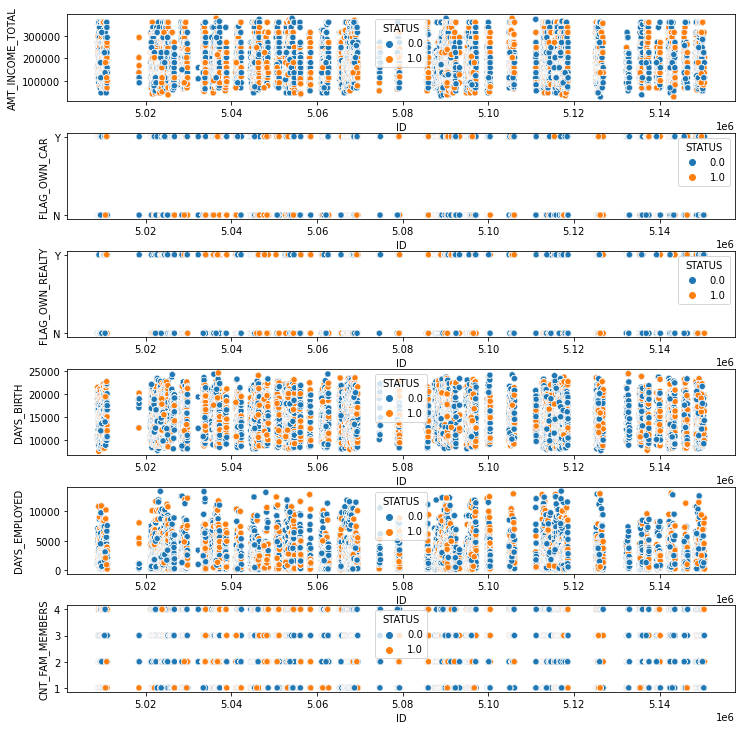

In [17]:
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(ncols=1, nrows=6, figsize=(10,10))
fig.tight_layout()
sns.scatterplot(data=df, x="ID", y="AMT_INCOME_TOTAL", hue='STATUS', ax=axs[0])
sns.scatterplot(data=df, x="ID", y="FLAG_OWN_CAR", hue='STATUS', ax=axs[1])
sns.scatterplot(data=df, x="ID", y="FLAG_OWN_REALTY", hue='STATUS', ax=axs[2])
sns.scatterplot(data=df, x="ID", y="DAYS_BIRTH", hue='STATUS', ax=axs[3])
sns.scatterplot(data=df, x="ID", y="DAYS_EMPLOYED", hue='STATUS', ax=axs[4])
sns.scatterplot(data=df, x="ID", y="CNT_FAM_MEMBERS", hue='STATUS', ax=axs[5])

In [18]:
# Observa-se que não há um padrão para aprovação ou reprovação para quando os dados são analisados separadamente  ->
# desta forma, o que diferencia entre o resultado da aprovação do crédito para o cliente, é o conjunto ->
# por completo dos fatores

<AxesSubplot:>

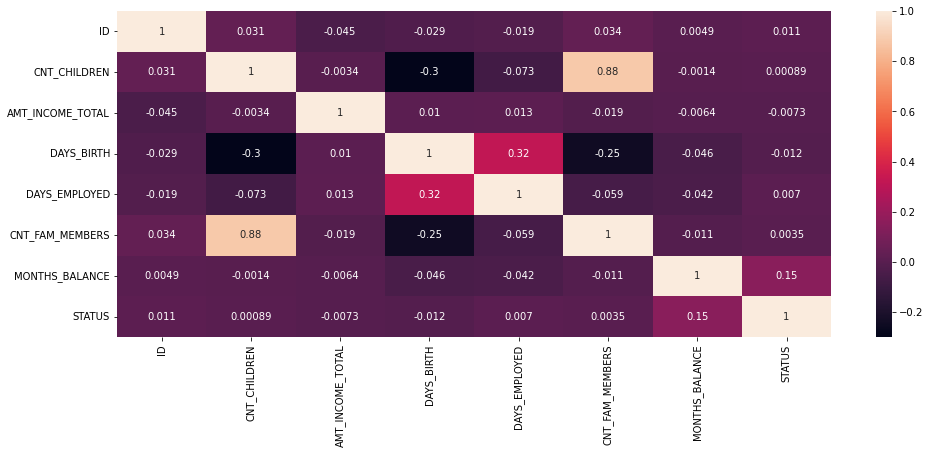

In [19]:
plt.figure(figsize=(16, 6))
correlation = df.corr(method='pearson')
sns.heatmap(correlation, annot=True)

#Para entender o comportamento entre as colunas foi criado um mapa de calor.
# As observações geradas sobre esta análise corroboram com a afirmação anterior, visto que ->
# a maior relação entre STATUS e quaisquer outras colunas chegou a um máximo de 15% de correspondência.

## 5. Criação de modelo de ML

### 5.1 KNN - K-NEAREST NEIGHBORS

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support

In [21]:
# Como abordado em tópicos anteriores, neste momento é realizada a conversão dos dados no formato "object" ->
# em dados numéricos para que seja possível a aplicação dos modelos

le = LabelEncoder()

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

In [22]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008806,1,1,1,0,112500.0,4,4,1,1,21474,1134,2.0,0.0,1.0
1,5008806,1,1,1,0,112500.0,4,4,1,1,21474,1134,2.0,-1.0,1.0
2,5008806,1,1,1,0,112500.0,4,4,1,1,21474,1134,2.0,-2.0,1.0
3,5008806,1,1,1,0,112500.0,4,4,1,1,21474,1134,2.0,-3.0,1.0
4,5008806,1,1,1,0,112500.0,4,4,1,1,21474,1134,2.0,-4.0,1.0


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = df.drop('STATUS', axis=1)
y = df['STATUS']

# Dividir a base de dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

# Criar um objeto KNeighborsClassifier com k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Treinar o modelo com os dados de treinamento
knn.fit(X_train, y_train)

# Fazer predições com os dados de teste
y_pred = knn.predict(X_test)

# Importar a métrica accuracy_score
from sklearn.metrics import accuracy_score

# Calcular a acurácia do modelo
accuracy_KNN = accuracy_score(y_test, y_pred)
print('Acurácia do modelo:', accuracy_KNN)

KNN_precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='macro')

Acurácia do modelo: 0.8462296942221145


<AxesSubplot:>

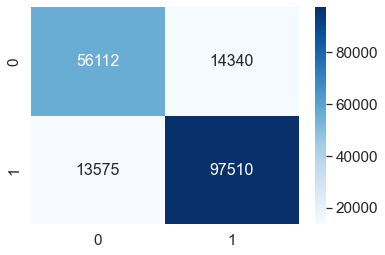

In [24]:
from sklearn.metrics import confusion_matrix

conf_matrix_KNN = confusion_matrix(y_test, y_pred)

sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_KNN, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g') # plotando a matriz de confusão

## 5.2 REGRESSÃO LOGÍSTICA

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

warnings.filterwarnings("ignore")

# Separar os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

# Criar o modelo de regressão logística
log_reg = LogisticRegression()

# Treinar o modelo usando os dados de treinamento
log_reg.fit(X_train, y_train)

# Fazer as previsões usando os dados de teste
y_pred = log_reg.predict(X_test)

accuracy_RL = accuracy_score(y_test, y_pred)
print('Acurácia do modelo:', accuracy_RL)

RL_precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='macro')

# Imprimir o relatório de classificação
print(classification_report(y_test, y_pred))

Acurácia do modelo: 0.6119138247299448
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     70452
         1.0       0.61      1.00      0.76    111085

    accuracy                           0.61    181537
   macro avg       0.31      0.50      0.38    181537
weighted avg       0.37      0.61      0.46    181537



<AxesSubplot:>

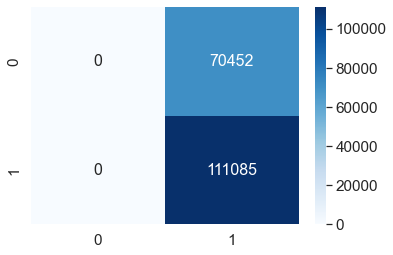

In [26]:
from sklearn.metrics import confusion_matrix

conf_matrix_RL = confusion_matrix(y_test, y_pred)

sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_RL, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g') # plotando a matriz de confusão

## 5.3 Árvore de Decisão

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

tree = DecisionTreeClassifier(random_state=13)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

accuracy_DT = accuracy_score(y_test, y_pred)
print('Acurácia do modelo:', accuracy_DT)

print(classification_report(y_test, y_pred))

DT_precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='macro')

Acurácia do modelo: 0.8791265692393286
              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84     70452
         1.0       0.90      0.90      0.90    111085

    accuracy                           0.88    181537
   macro avg       0.87      0.87      0.87    181537
weighted avg       0.88      0.88      0.88    181537



<AxesSubplot:>

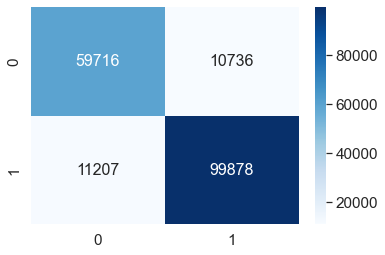

In [28]:
from sklearn.metrics import confusion_matrix

conf_matrix_DT = confusion_matrix(y_test, y_pred)

sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_DT, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g') # plotando a matriz de confusão

## 5.4 Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

# cria o modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# treina o modelo
rf.fit(X_train, y_train)

# faz a predição
y_pred = rf.predict(X_test)

accuracy_RF = accuracy_score(y_test, y_pred)
print('Acurácia do modelo:', accuracy_RF)

# imprime o classification report
print(classification_report(y_test, y_pred))

RF_precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='macro')

Acurácia do modelo: 0.8982080787938547
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87     70452
         1.0       0.92      0.92      0.92    111085

    accuracy                           0.90    181537
   macro avg       0.89      0.89      0.89    181537
weighted avg       0.90      0.90      0.90    181537



<AxesSubplot:>

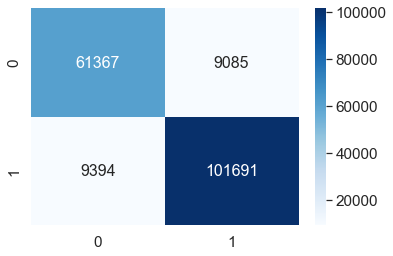

In [30]:
from sklearn.metrics import confusion_matrix

conf_matrix_RF = confusion_matrix(y_test, y_pred)

sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_RF, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g') # plotando a matriz de confusão

## 5.5 Resumo dos Resultados:

In [31]:
print("K-Nearest Neighbors - Macro Avg - Precision: {:.2f}".format(KNN_precision))
print("Regressão Logística - Macro Avg - Precision: {:.2f}".format(RL_precision))
print("Árvore de Decisão - Macro Avg - Precision: {:.2f}".format(DT_precision))
print("Random Forest - Macro Avg - Precision: {:.2f}".format(RF_precision))

K-Nearest Neighbors - Macro Avg - Precision: 0.84
Regressão Logística - Macro Avg - Precision: 0.31
Árvore de Decisão - Macro Avg - Precision: 0.87
Random Forest - Macro Avg - Precision: 0.89


Text(0.5, 0, 'Macro Avg')

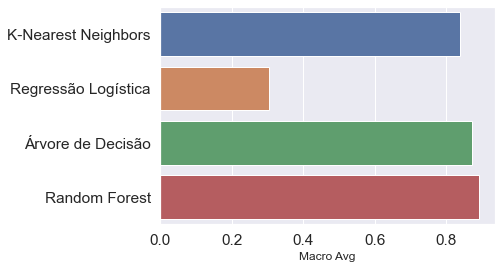

In [32]:
x = np.array(['K-Nearest Neighbors', 'Regressão Logística', 'Árvore de Decisão', 'Random Forest'])
y = np.array([KNN_precision, RL_precision, DT_precision, RF_precision])

graf = sns.barplot(y,x, orient = 'h')
plt.xlabel("Macro Avg", size = 12)